In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**QUESTÃO 1.1**

In [4]:
import pandas as pd
import math

def entropia(subconjunto, coluna_alvo="conc"):
    total = len(subconjunto)
    if total == 0:
        return 0
    contagens = subconjunto[coluna_alvo].value_counts()
    ent = 0
    for c in contagens:
        p = c / total
        ent -= p * math.log2(p)
    return ent

def ganho_informacao(df, atributo, coluna_alvo="conc"):
    H_total = entropia(df, coluna_alvo)
    total = len(df)
    entropia_ponderada = 0
    entropias_valores = {}
    for valor, subconjunto in df.groupby(atributo):
        H_val = entropia(subconjunto, coluna_alvo)
        entropias_valores[valor] = (len(subconjunto), H_val)
        entropia_ponderada += (len(subconjunto) / total) * H_val
    ganho = H_total - entropia_ponderada
    return ganho, entropias_valores

df = pd.read_csv("/content/drive/MyDrive/restaurantev2.csv", sep=";", encoding="latin1")

resultados = {}
for coluna in df.columns:
    if coluna not in ["Exemplo", "conc"]:
        ganho, ents = ganho_informacao(df, coluna, "conc")
        resultados[coluna] = {"ganho": ganho, "entropias": ents}

for atributo, valores in resultados.items():
    print(f"\nAtributo: {atributo}")
    print(f"  Ganho de informação: {valores['ganho']:.3f}")
    print("  Entropia por valor:")
    for valor, (n, h) in valores["entropias"].items():
        print(f"    {valor:10s} ({n} instâncias) -> H = {h:.3f}")



Atributo: Alternativo
  Ganho de informação: 0.000
  Entropia por valor:
    Não        (6 instâncias) -> H = 1.000
    Sim        (6 instâncias) -> H = 1.000

Atributo: Bar
  Ganho de informação: 0.000
  Entropia por valor:
    Não        (6 instâncias) -> H = 1.000
    Sim        (6 instâncias) -> H = 1.000

Atributo: Sex/Sab
  Ganho de informação: 0.021
  Entropia por valor:
    Não        (7 instâncias) -> H = 0.985
    Sim        (5 instâncias) -> H = 0.971

Atributo: fome
  Ganho de informação: 0.196
  Entropia por valor:
    Não        (5 instâncias) -> H = 0.722
    Sim        (7 instâncias) -> H = 0.863

Atributo: Cliente
  Ganho de informação: 0.541
  Entropia por valor:
    Alguns     (4 instâncias) -> H = 0.000
    Cheio      (6 instâncias) -> H = 0.918
    Nenhum     (2 instâncias) -> H = 0.000

Atributo: Preço
  Ganho de informação: 0.196
  Entropia por valor:
    R          (7 instâncias) -> H = 0.985
    RR         (2 instâncias) -> H = 0.000
    RRR        (3 instânci

**QUESTÃO 1.2**

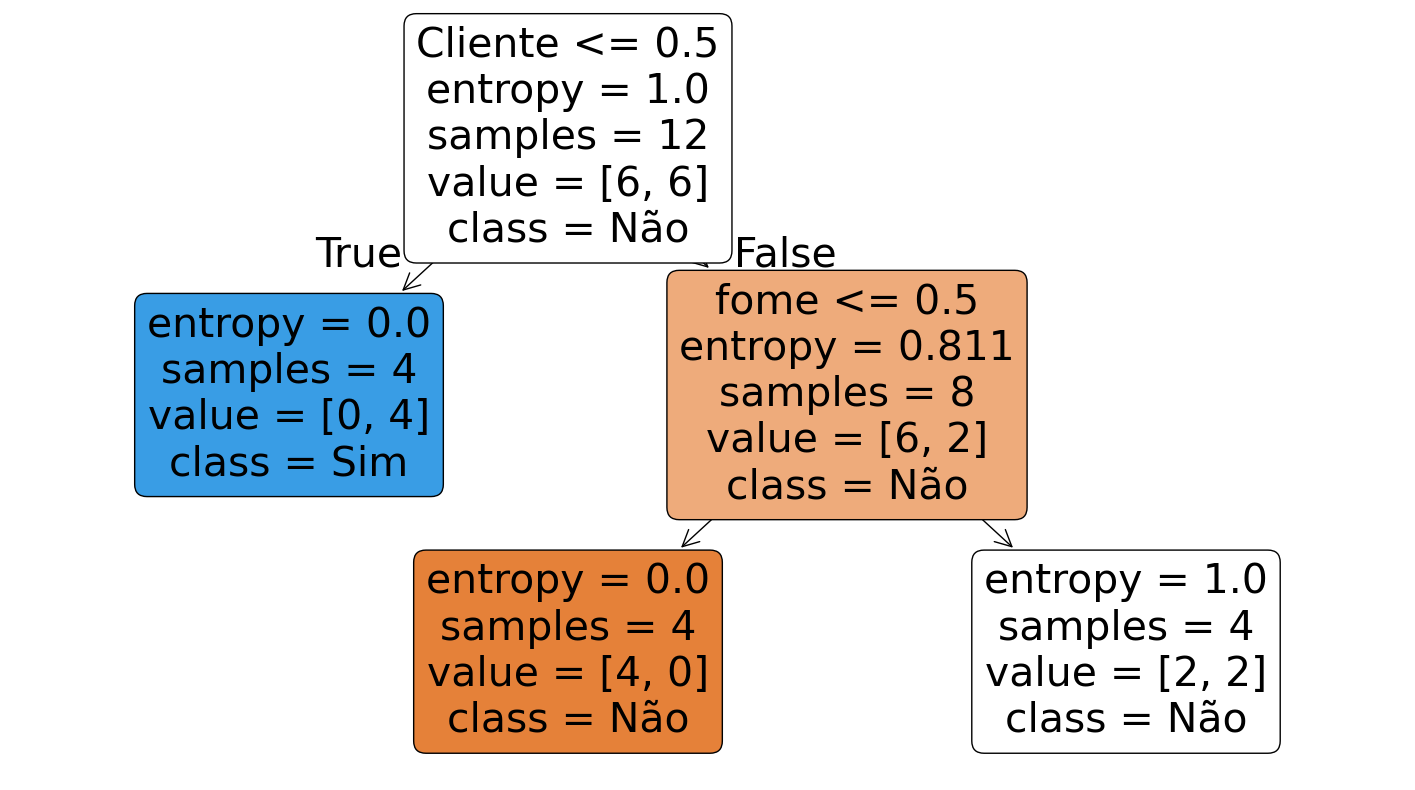

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

X = df.drop(columns=["Exemplo", "conc"])
y = df["conc"]

encoder = OrdinalEncoder()
X_encoded = X.copy()
X_encoded[:] = encoder.fit_transform(X_encoded)

y_encoded = y.map({"Não": 0, "Sim": 1})

clf = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42)
clf.fit(X_encoded, y_encoded)

plt.figure(figsize=(18,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["Não", "Sim"],
    filled=True,
    rounded=True
)
plt.show()

**QUESTÃO 2**

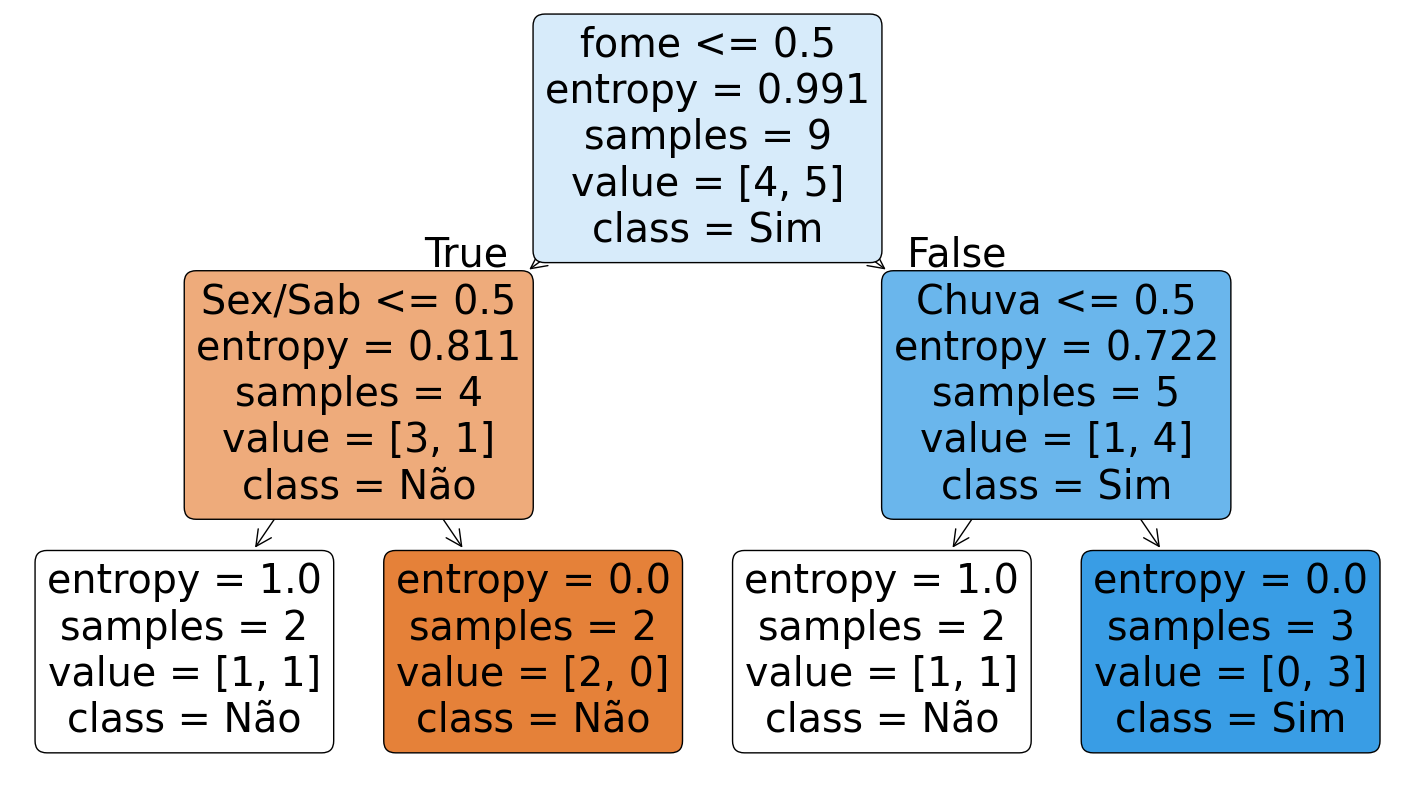

In [13]:
from sklearn.model_selection import train_test_split

cliente_map = {"Nenhum": 0, "Alguns": 1, "Cheio": 2}
df["Cliente"] = df["Cliente"].map(cliente_map)

X = df.drop(columns=["Exemplo", "conc"])
y = df["conc"].map({"Não": 0, "Sim": 1})

colunas_para_codificar = [c for c in X.columns if c != "Cliente"]
encoder = OrdinalEncoder()
X[colunas_para_codificar] = encoder.fit_transform(X[colunas_para_codificar])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42)
clf.fit(X_train, y_train)

plt.figure(figsize=(18,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["Não", "Sim"],
    filled=True,
    rounded=True
)
plt.show()


**QUESTÃO 3**

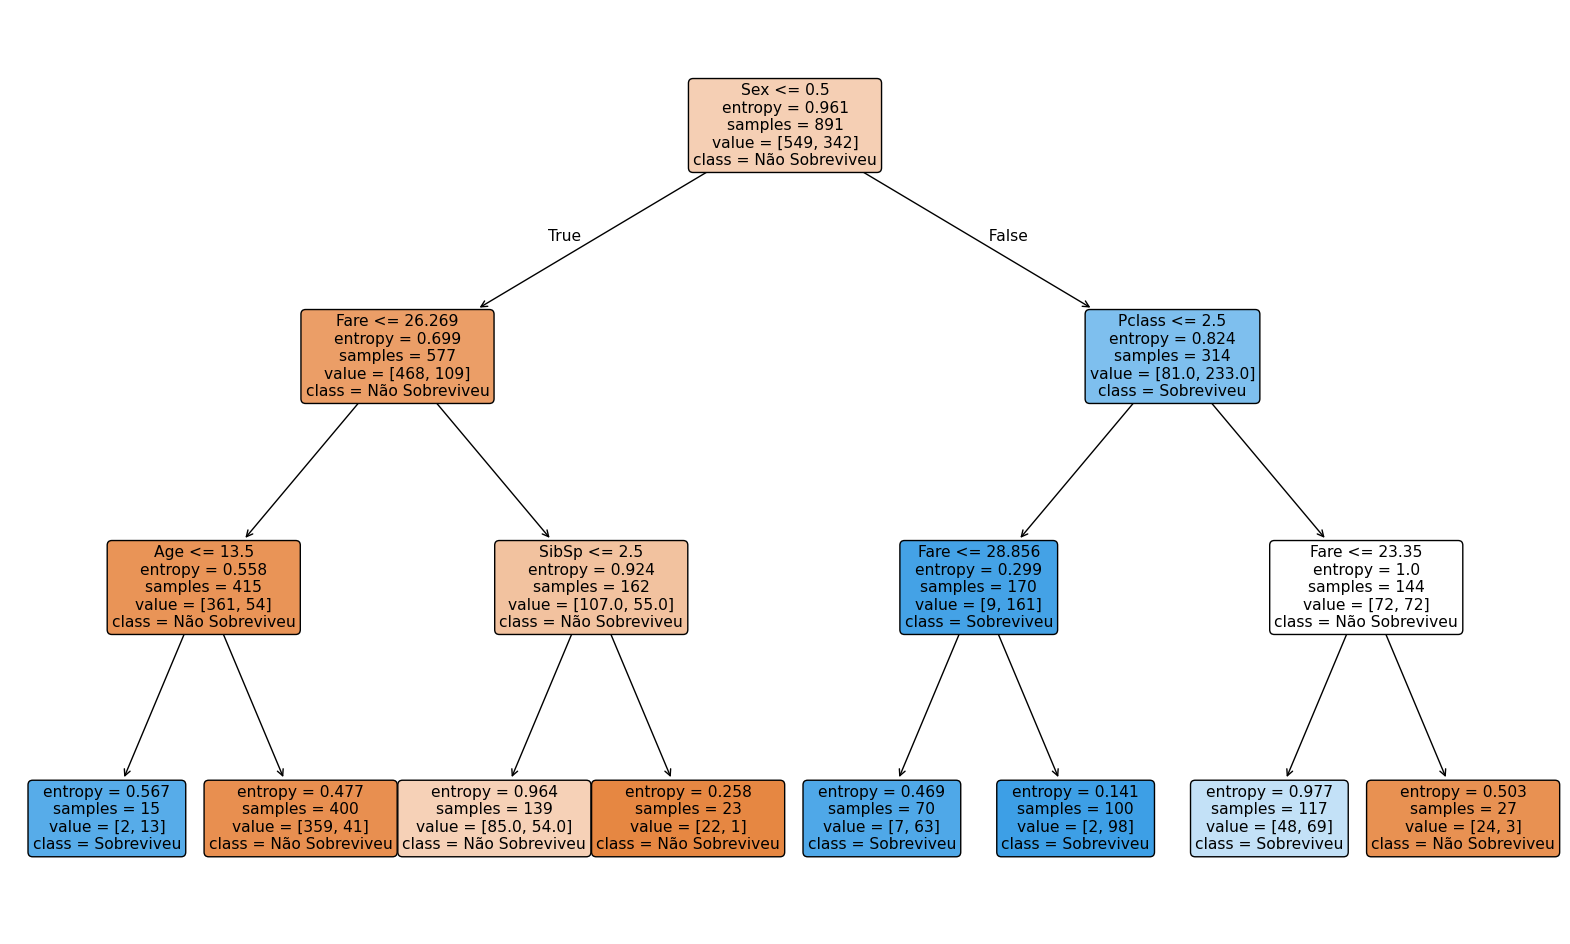

Regras de sobrevivência e mortalidade:

|--- Sex <= 0.50
|   |--- Fare <= 26.27
|   |   |--- Age <= 13.50
|   |   |   |--- class: 1
|   |   |--- Age >  13.50
|   |   |   |--- class: 0
|   |--- Fare >  26.27
|   |   |--- SibSp <= 2.50
|   |   |   |--- class: 0
|   |   |--- SibSp >  2.50
|   |   |   |--- class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- Fare <= 28.86
|   |   |   |--- class: 1
|   |   |--- Fare >  28.86
|   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 23.35
|   |   |   |--- class: 1
|   |   |--- Fare >  23.35
|   |   |   |--- class: 0



In [15]:
from sklearn.tree import export_text

# =============================
# Carregar datasets Titanic
# =============================
df_train = pd.read_csv("/content/drive/MyDrive/titanic/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/titanic/test.csv")

# =============================
# Selecionar atributos relevantes
# =============================
atributos = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = df_train[atributos].copy()
y_train = df_train['Survived']
X_test = df_test[atributos].copy()

# =============================
# Tratar valores ausentes usando .loc
# =============================
X_train.loc[:, 'Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_test.loc[:, 'Age'] = X_test['Age'].fillna(X_train['Age'].median())

X_train.loc[:, 'Fare'] = X_train['Fare'].fillna(X_train['Fare'].median())
X_test.loc[:, 'Fare'] = X_test['Fare'].fillna(X_train['Fare'].median())

X_train.loc[:, 'Embarked'] = X_train['Embarked'].fillna('S')
X_test.loc[:, 'Embarked'] = X_test['Embarked'].fillna('S')

# =============================
# Codificar variáveis categóricas
# =============================
map_sex = {'male': 0, 'female': 1}
map_embarked = {'C': 0, 'Q': 1, 'S': 2}

X_train.loc[:, 'Sex'] = X_train['Sex'].map(map_sex)
X_test.loc[:, 'Sex'] = X_test['Sex'].map(map_sex)

X_train.loc[:, 'Embarked'] = X_train['Embarked'].map(map_embarked)
X_test.loc[:, 'Embarked'] = X_test['Embarked'].map(map_embarked)

# =============================
# Treinar árvore de decisão
# =============================
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# =============================
# Plotar árvore
# =============================
plt.figure(figsize=(20,12))
plot_tree(
    clf,
    feature_names=X_train.columns,
    class_names=['Não Sobreviveu','Sobreviveu'],
    filled=True,
    rounded=True
)
plt.show()

# =============================
# Extrair regras de mortalidade
# =============================
regras = export_text(clf, feature_names=list(X_train.columns))
print("Regras de sobrevivência e mortalidade:\n")
print(regras)

**QUESTÃO 7**

In [18]:
import numpy as np
import pandas as pd

# Matriz de confusão (linhas = reais, colunas = previstos)
conf_matrix = np.array([
    [10, 4, 2, 1],
    [1, 15, 2, 0],
    [2, 3, 20, 5],
    [4, 1, 2, 50]
])

classes = ['A', 'B', 'C', 'D']
results = {}

# Métricas por classe
for i, cls in enumerate(classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results[cls] = {
        'TP': TP,
        'FN': FN,
        'FP': FP,
        'TN': TN,
        'Precisão': precision,
        'Recall': recall,
        'F1-Score': f1
    }

df_results = pd.DataFrame(results).T
df_results[['Precisão','Recall','F1-Score']] = df_results[['Precisão','Recall','F1-Score']].round(3)

# Estatísticas totais (micro)
TP_total = conf_matrix.trace()  # soma dos TP
FP_total = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FP_total = FP_total.sum()
FN_total = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
FN_total = FN_total.sum()
TN_total = conf_matrix.sum() - (TP_total + FP_total + FN_total)

precision_micro = TP_total / (TP_total + FP_total)
recall_micro = TP_total / (TP_total + FN_total)
f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro)

df_total = pd.DataFrame({
    'TP': [TP_total],
    'FN': [FN_total],
    'FP': [FP_total],
    'TN': [TN_total],
    'Precisão': [round(precision_micro, 3)],
    'Recall': [round(recall_micro, 3)],
    'F1-Score': [round(f1_micro, 3)]
}, index=['Total'])

# Exibir resultados
print("Métricas por classe:\n", df_results, "\n")
print("Métricas totais (micro):\n", df_total)

Métricas por classe:
      TP    FN   FP    TN  Precisão  Recall  F1-Score
A  10.0   7.0  7.0  98.0     0.588   0.588     0.588
B  15.0   3.0  8.0  96.0     0.652   0.833     0.732
C  20.0  10.0  6.0  86.0     0.769   0.667     0.714
D  50.0   7.0  6.0  59.0     0.893   0.877     0.885 

Métricas totais (micro):
        TP  FN  FP  TN  Precisão  Recall  F1-Score
Total  95  27  27 -27     0.779   0.779     0.779
